In [10]:
import sys
import os
import importlib   

sys.path.append(os.path.join(os.getcwd(), 'NeuralNetworks'))
import Fully_connected_network as FC
importlib.reload(FC)

import torch
import matplotlib.pyplot as plt

In [5]:
if torch.cuda.is_available():
   device = torch.device("cuda")
   print("Running on the GPU")
else:
   device = torch.device("cpu")
   print("Running on the CPU")

torch.manual_seed(12)
torch.set_default_dtype(torch.float64)

Running on the GPU


In [6]:
def u_exact(x:torch.Tensor):
    # u_g = torch.log(x+2) + torch.cos(2*x + x**3)
    u_g = torch.sin(2*x + 1) + 0.2*torch.exp(1.3*x)
    # u_g = x**3/(0.01 + x**4)
    return u_g

In [8]:
x_train = torch.linspace(-1.05, 1.05, 300)[:, None]
u_train = u_exact(x_train)
x_intp = torch.linspace(-1, 1, 200)[:, None]
u_intp = u_exact(x_intp)

lb, ub = x_train.min(), x_train.max()
u_scale = u_train.abs().max()/2
# u_train = u_train/u_scale

model1 = FC.FullyConnectedNetwork(domain_bounds=[lb, ub], kappa=1, input_dim=1, hidden_size=20, actv=0)
criterion = torch.nn.MSELoss()
model1_optimizer_adam = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_optimizer_lbfgs = torch.optim.LBFGS(model1.parameters(), tolerance_change=1e-11, line_search_fn='strong_wolfe')
n_iter_adam = 5000
n_iter_lbfgs = 1001

for iter_i in range(n_iter_adam):
    model1_optimizer_adam.zero_grad()

    u_pred = model1(x_train)
    loss = criterion(u_pred, u_train)*(u_scale**2)
    loss.backward()
    model1_optimizer_adam.step()

    if iter_i % 100 == 0:
        print(f"Iteration {iter_i}, loss: {loss.item()}")

def closure_lbfgs():
    model1_optimizer_lbfgs.zero_grad()
    u_pred = model1(x_train)
    loss = criterion(u_pred, u_train)*(u_scale**2)
    loss.backward()
    return loss

for iter_i in range(n_iter_lbfgs):
    model1_optimizer_lbfgs.step(closure_lbfgs)
    if iter_i % 100 == 0:
        print(f"Iteration {iter_i}, loss: {loss.item()}")

u_pred = model1(x_intp)
residue_order1 = u_exact(x_intp) - model1(x_intp)

epsilon1 = torch.sqrt(torch.mean(residue_order1**2))
residue_order1 = residue_order1/epsilon1

Iteration 0, loss: 0.43927517527688603
Iteration 100, loss: 0.031847024427464315
Iteration 200, loss: 0.010114284894544034
Iteration 300, loss: 0.002922768800536334
Iteration 400, loss: 0.002476942798374832
Iteration 500, loss: 0.0021757031757623454
Iteration 600, loss: 0.0019338800274498976
Iteration 700, loss: 0.0017307617648566309
Iteration 800, loss: 0.0015541939361454246
Iteration 900, loss: 0.0013953758640707647
Iteration 1000, loss: 0.0012475446111560441
Iteration 1100, loss: 0.0011048588709304263
Iteration 1200, loss: 0.0009616190031552583
Iteration 1300, loss: 0.0008119788781909982
Iteration 1400, loss: 0.0006506982779915616
Iteration 1500, loss: 0.0004767109773869591
Iteration 1600, loss: 0.0003013766228893187
Iteration 1700, loss: 0.00015469325851054827
Iteration 1800, loss: 6.593255750216309e-05
Iteration 1900, loss: 2.8995155685580892e-05
Iteration 2000, loss: 1.6719461798701178e-05
Iteration 2100, loss: 1.246188735647882e-05
Iteration 2200, loss: 1.0554126485678421e-05
It

In [9]:
# Second stage of training
u_train2 = residue_order1.detach()
nb_zeros = torch.where(u_train2[:-1, 0] * u_train2[1:, 0] < 0)[0]
kappa2 = 3*(nb_zeros.shape[0])
u_scale = u_train2.abs().max()/2

model2 = FC.FullyConnectedNetwork(domain_bounds=[lb, ub], kappa=kappa2, input_dim=1, hidden_size=20, actv=1)
model2_optimizer_adam = torch.optim.Adam(model2.parameters(), lr=0.001)
model2_optimizer_lbfgs = torch.optim.LBFGS(model2.parameters(), tolerance_change=1e-11, line_search_fn='strong_wolfe')

n_iter_adam = 5000

for iter_i in range(n_iter_adam):
    model2_optimizer_adam.zero_grad()

    u_pred2 = model2(u_train2)
    loss = criterion(u_pred2, u_train2)*(u_scale**2)
    loss.backward()
    model2_optimizer_adam.step()

    if iter_i % 100 == 0:
        print(f"Iteration {iter_i}, loss: {loss.item()}")

residue_order1_pred = model2(u_train2)

Iteration 0, loss: 1.2133258649116028
Iteration 100, loss: 0.0018161932513012166
Iteration 200, loss: 0.0006630555996615751
Iteration 300, loss: 0.0003135835607316692
Iteration 400, loss: 0.00014930540259592718
Iteration 500, loss: 8.70969291027033e-05
Iteration 600, loss: 6.0114155558696845e-05
Iteration 700, loss: 4.57836473066855e-05
Iteration 800, loss: 3.706428498631381e-05
Iteration 900, loss: 3.116729997081184e-05
Iteration 1000, loss: 2.6827397809306135e-05
Iteration 1100, loss: 2.342345684676473e-05
Iteration 1200, loss: 2.0627662177243374e-05
Iteration 1300, loss: 1.825510394292716e-05
Iteration 1400, loss: 1.6196017031713356e-05
Iteration 1500, loss: 1.4382650611274039e-05
Iteration 1600, loss: 1.2771568843438575e-05
Iteration 1700, loss: 1.1333630185164395e-05
Iteration 1800, loss: 1.0048175160566987e-05
Iteration 1900, loss: 8.899630743399512e-06
Iteration 2000, loss: 7.875513373591035e-06
Iteration 2100, loss: 6.965236356440634e-06
Iteration 2200, loss: 6.159380820528647e

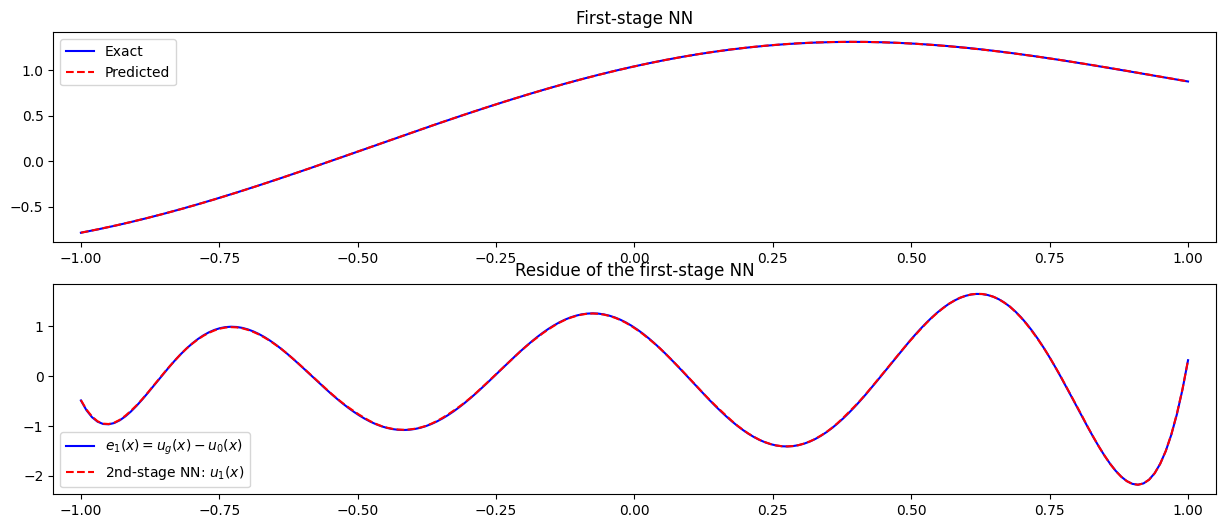

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6))
axes[0].plot(x_intp, u_intp, 'b-', label='Exact')
axes[0].plot(x_intp, u_pred.detach(), 'r--', label='Predicted')
axes[0].set_xlim(lb, ub)
axes[0].legend()
axes[0].set_title('First-stage NN')

axes[1].plot(x_intp, residue_order1.detach(), 'b-', label=r'$e_1(x) = u_g(x) - u_0(x)$')
axes[1].plot(x_intp, residue_order1_pred.detach(), 'r--', label=r'2nd-stage NN: $u_1(x)$')
axes[1].set_xlim(lb, ub)
axes[1].legend()
axes[1].set_title('Residue of the first-stage NN')

plt.show()